# Visualization

This notebook walks through how to visualize the graphs you create. For this example we will use a prebuilt graph, but this works with ANY graphs.

## Set up the chat model and tools

Here we will define the chat model and tools that we want to use.
Importantly, this model MUST support OpenAI function calling.

In [1]:
# !pip install -r ./requirements.txt
#!pip install grandalf
#!pip install tabulate

In [2]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import chat_agent_executor

In [3]:
# Optional to not need .env
import os
os.environ['TAVILY_API_KEY'] = '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'
os.environ['OPENAI_API_KEY'] = ''

tools = [TavilySearchResults(max_results=1)]
model = ChatOpenAI()

## Create executor

We can now use the high level interface to create the executor

In [4]:
#app = chat_agent_executor.create_function_calling_executor(model, tools)
from agents import chain
app = chain

In [6]:
### RUN

from agents import get_answer
from langchain_core.messages import HumanMessage

def enter_chain(full_messages_history: list[str]):
    results = {
        "messages": [],
    }
    for i in range(len(full_messages_history)):
        if i % 2 == 0:
            results["messages"].append(HumanMessage(content=full_messages_history[i]))
        else:
            results["messages"].append(HumanMessage(content=full_messages_history[i], is_user=False))
    return results

research_chain = enter_chain | chain


full_messages_history = ["I am 24 with 500 k euros a month. what is the best car for me? Please choose how to talk about me"]
for i in range(3):
    print('START NEW ITERATION')
    print(full_messages_history)
    ideas = []
    for s in research_chain.stream(
        full_messages_history, {"recursion_limit": 25}
    ):
        if "__end__" not in s:
            print(s)
            ideas.append(s)
            print("---")

    j = 0
    while 'conversation' not in ideas[-j]:
        j += 1
    answer = ideas[-j]['conversation']['messages'][0].content
    print("ANSWER:", answer)
    full_messages_history.append("No, choose another one")

START NEW ITERATION
['I am 24 with 500 k euros a month. what is the best car for me? Please choose how to talk about me']
{'user_profile': {'profile': 'The Luxurious Minimalist'}}
---
{'supervisor': {'next': 'retrieve_data_from_database'}}
---


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df[(df['currency'] == 'EUR') & (df['price'] <= 500000)].sort_values('price').head()"}`
responded: It seems like you are looking for a car recommendation based on your profile as "The Luxurious Minimalist," and your monthly budget of 500,000 euros. To provide you with the best car recommendation, I will retrieve relevant data from the database. Let's start by retrieving the necessary information.

   market_id      model_id              name        short_name          brand   
53     de_DE  42089313_000  EQT 200 standard  EQT 200 standard  Mercedes-Benz  \
20     de_DE       2437011           EQA 250           EQA 250  Mercedes-Benz   
21     de_DE       2437021 

GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [21]:
print("ANSWER:", answer)


ANSWER: Based on your age and budget, I recommend the Mercedes-Benz EQS. It offers luxury, cutting-edge technology, and high performance, making it a perfect fit for a young professional like yourself with a generous income. The EQS combines elegance with sustainability, reflecting your sophisticated taste and environmental consciousness.


## Ascii

We can easily visualize this graph in ascii

In [7]:
app.get_graph().print_ascii()

                        +-----------+                          
                        | __start__ |                          
                        +-----------+                          
                               *                               
                               *                               
                               *                               
                       +--------------+                        
                       | user_profile |                        
                       +--------------+                        
                               *                               
                               *                               
                               *                               
                        +------------+                         
                        | supervisor |                         
                      **+------------+****                     
                 *****         *        

## Mermaid

We can also convert a graph class into Mermaid syntax.

In [8]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__[__start__]:::startclass;
	__end__[__end__]:::endclass;
	retrieve([retrieve]):::otherclass;
	conversation([conversation]):::otherclass;
	supervisor([supervisor]):::otherclass;
	user_profile([user_profile]):::otherclass;
	condition([condition]):::otherclass;
	__start__ --> user_profile;
	conversation --> supervisor;
	retrieve --> supervisor;
	user_profile --> supervisor;
	supervisor --> condition;
	condition -. retrieve_data_from_database .-> retrieve;
	condition -. FINISH .-> __end__;
	condition -. initiate_a_conversation_with_a_client .-> conversation;
	classDef startclass fill:#ffdfba;
	classDef endclass fill:#baffc9;
	classDef otherclass fill:#fad7de;



## PNG

If prefered, we could render the Graph into a  `.png`. Here we could use three options:

- Using graphviz (which requires `pip install graphviz`)
- Using Mermaid + Pyppeteer (requires `pip install pyppeteer`)
- Using Mermaid.ink API (does not require additional packages)

In [16]:
from IPython.display import display, HTML
import base64

def display_image(image_bytes: bytes, width=800):
    decoded_img_bytes = base64.b64encode(image_bytes).decode('utf-8')
    html = f'<img src="data:image/png;base64,{decoded_img_bytes}" style="width: {width}px;" />'
    display(HTML(html))

### Using Mermaid + Pyppeteer

In [10]:
#!pip install pyppeteer
# !pip install nest_asyncio


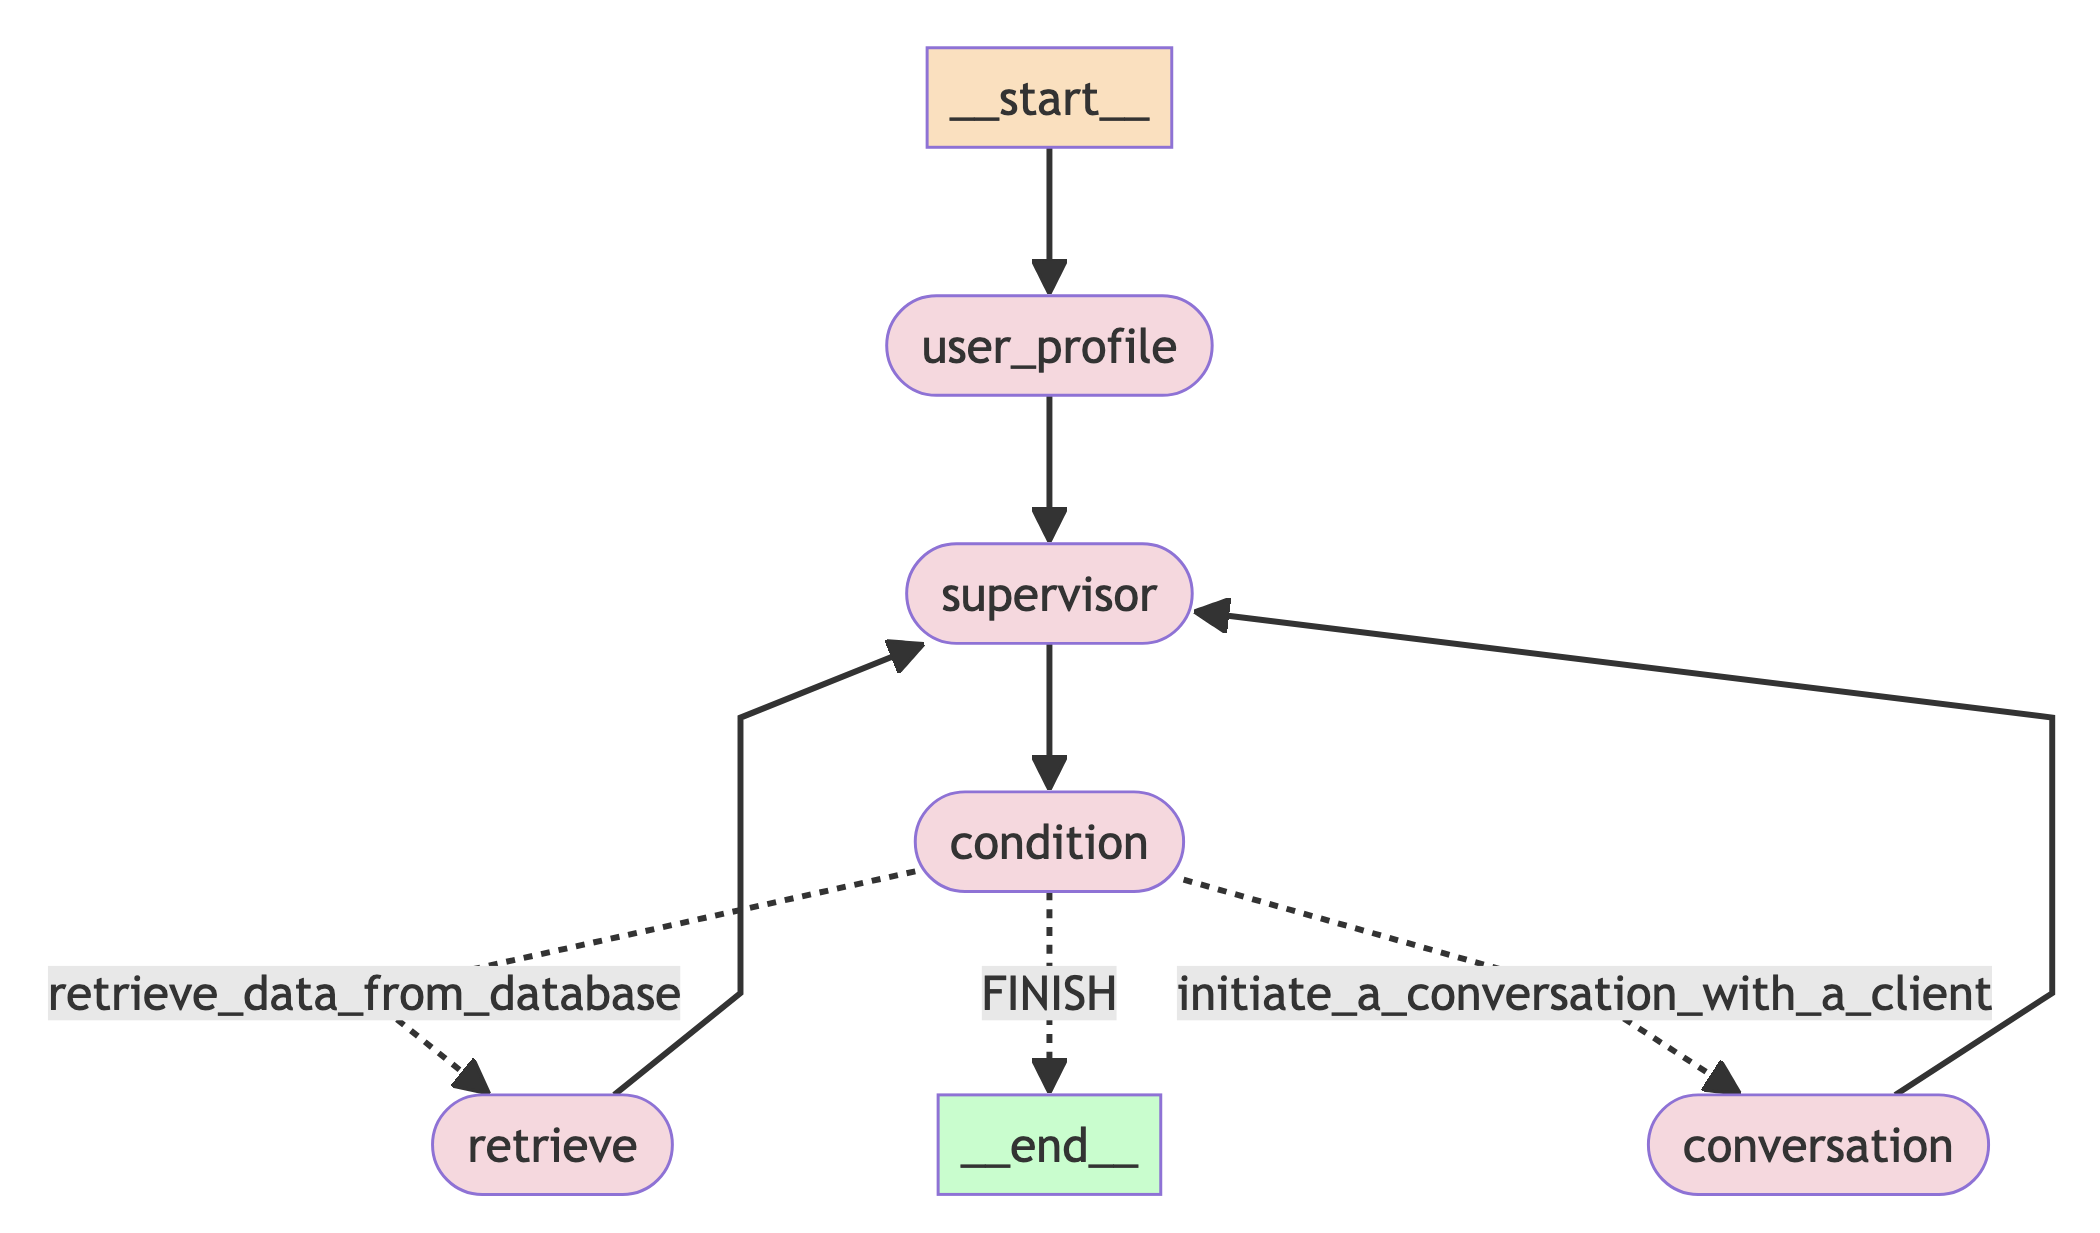

In [18]:
import nest_asyncio
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod

nest_asyncio.apply() # Required for Jupyter Notebook to run async functions

display_image(app.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    node_colors=NodeColors(start="#ffdfba", end="#baffc9", other="#fad7de"),
    wrap_label_n_words=9,
    output_file_path=None,
    draw_method=MermaidDrawMethod.PYPPETEER,
    background_color="white",
    padding=10,
))

### Using Mermaid.Ink

In [13]:
display_image(app.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.API
))

TypeError: Graph.draw_mermaid_png() got an unexpected keyword argument 'width'

## Excluding condition nodes
By default, condition nods like 'should_continue' will be added. In case you have a big graph and want to exclude these or simplicity, you can use add_condition_nodes parameter


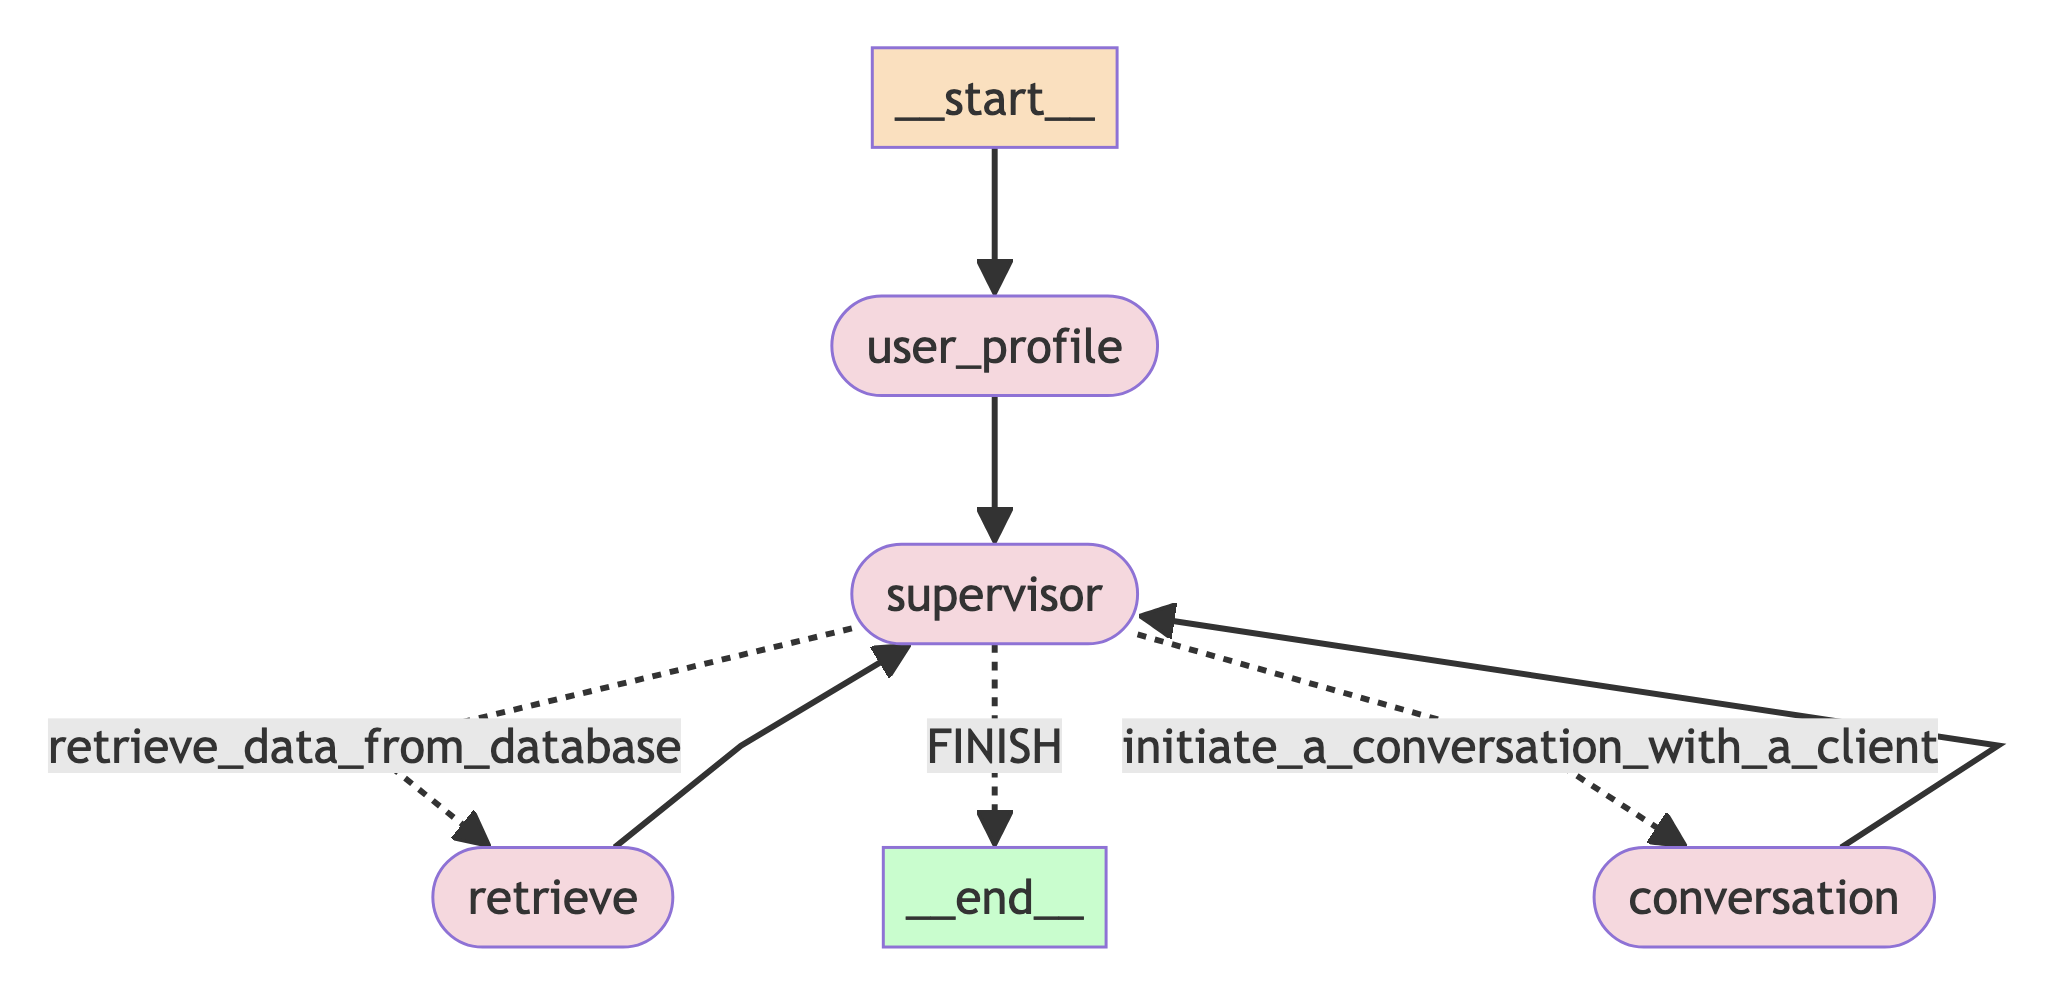

In [17]:
display_image(app.get_graph(add_condition_nodes=False).draw_mermaid_png(
    draw_method=MermaidDrawMethod.PYPPETEER,
))
